In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import dask.dataframe as dd
import dask.distributed
import numpy as np
import pandas as pd
# import geopandas as gpd

from matplotlib.colors import SymLogNorm as symlog
from matplotlib import rcParams

import sklearn, sklearn.cluster
import matplotlib.pyplot as plt
import palettable

import seaborn as sns

import netCDF4
import geopandas


pd.options.display.max_rows = 300
pd.options.display.max_columns = 100

In [2]:
client = dask.distributed.Client()

In [3]:
rcParams['font.sans-serif'] = ('Helvetica', 'Arial', 'Open Sans', 'Bitstream Vera Sans')
rcParams['font.size'] = 12
rcParams['font.stretch'] = 'normal'
rcParams['font.weight'] = 'normal'

rcParams['savefig.dpi'] = 150
rcParams['figure.dpi'] = 150
import seaborn as sns

import os.path
homedirpath = os.path.expanduser('~')
fontdirpath = ''
if '/Users/' in homedirpath:
    fontdirpath = os.path.join(homedirpath, 'Library/Fonts/')
else:
    fontdirpath = os.path.join(homedirpath, '.fonts/')
fontsize2 = 'size={0:0.1f}'.format(12)
rcParams['mathtext.it'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'HelveticaOblique.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.rm'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'Helvetica.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.tt'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'Helvetica.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.bf'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'HelveticaBold.ttf:' +
                            fontsize2
                            ).format(fontdirpath))
rcParams['mathtext.cal'] = ((':family=sans-serif:style=normal:variant='
                             'normal:weight=normal:stretch=normal:file='
                             '{0}/Helvetica.ttf:' +
                             fontsize2
                             ).format(fontdirpath))
rcParams['mathtext.sf'] = ((':family=sans-serif:style=normal:variant='
                            'normal:weight=normal:stretch=normal:file={0}/'
                            'Helvetica.ttf:' +
                            fontsize2
                            ).format(fontdirpath))

# Section 1: Sample 10 random rows from the dataset, show with human readable names for blog post as HTML

In [4]:
df = dd.read_parquet('/data/all_trips.parquet', index='trip_id', 
    columns='pickup_datetime dropoff_datetime pickup_taxizone_id dropoff_taxizone_id'.split())

/home/shekhar/anaconda3/lib/python3.6/site-packages/fastparquet/api.py:436: UserWarning: Regression warning: found category spec from fastparquet <= 0.0.6
  warnings.warn('Regression warning: found category spec from '


In [37]:
tzdf = geopandas.read_file('../shapefiles/taxi_zones.shp')

In [6]:
df2 = df.sample(frac=1.0e-6, random_state=42).compute()

In [7]:
df2 = df2.dropna()

In [8]:
df3 = df2.merge(
    tzdf['LocationID borough zone'.split()], left_on='pickup_taxizone_id', right_on='LocationID'
)
df3['pickup_location'] = df3.borough.map(str) + " | " +  df3.zone
df3 = df3.drop('LocationID borough zone'.split(), axis=1)

df3 = df3.merge(
    tzdf['LocationID borough zone'.split()], left_on='dropoff_taxizone_id', right_on='LocationID'
)
df3['dropoff_location'] = df3.borough.map(str) + " | " +  df3.zone
df3 = df3.drop('LocationID borough zone'.split(), axis=1)
df3 = df3.sample(frac=1, replace=False, random_state=42).reset_index(drop=True)

In [9]:
df3.head(10).sort_values('pickup_datetime').reset_index(drop=True).to_html().replace("""\n""", "")

'<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>pickup_datetime</th>      <th>dropoff_datetime</th>      <th>pickup_taxizone_id</th>      <th>dropoff_taxizone_id</th>      <th>pickup_location</th>      <th>dropoff_location</th>    </tr>  </thead>  <tbody>    <tr>      <th>0</th>      <td>2009-04-02 15:02:43</td>      <td>2009-04-02 15:22:45</td>      <td>138</td>      <td>229</td>      <td>Queens | LaGuardia Airport</td>      <td>Manhattan | Sutton Place/Turtle Bay North</td>    </tr>    <tr>      <th>1</th>      <td>2009-05-03 01:34:00</td>      <td>2009-05-03 01:36:00</td>      <td>79</td>      <td>164</td>      <td>Manhattan | East Village</td>      <td>Manhattan | Midtown South</td>    </tr>    <tr>      <th>2</th>      <td>2010-10-09 00:48:38</td>      <td>2010-10-09 01:00:55</td>      <td>79</td>      <td>237</td>      <td>Manhattan | East Village</td>      <td>Manhattan | Upper East Side South</td>    </tr>    <tr>      <

In [10]:
from IPython.display import HTML
HTML(df3.head(10).sort_values('pickup_datetime').reset_index(drop=True).to_html())

,pickup_datetime,dropoff_datetime,pickup_taxizone_id,dropoff_taxizone_id,pickup_location,dropoff_location
0,2009-04-02 15:02:43,2009-04-02 15:22:45,138,229,Queens | LaGuardia Airport,Manhattan | Sutton Place/Turtle Bay North
1,2009-05-03 01:34:00,2009-05-03 01:36:00,79,164,Manhattan | East Village,Manhattan | Midtown South
2,2010-10-09 00:48:38,2010-10-09 01:00:55,79,237,Manhattan | East Village,Manhattan | Upper East Side South
3,2011-09-07 10:03:00,2011-09-07 10:09:00,113,211,Manhattan | Greenwich Village North,Manhattan | SoHo
4,2012-07-21 20:34:00,2012-07-21 20:39:00,211,114,Manhattan | SoHo,Manhattan | Greenwich Village South
5,2013-05-31 17:45:06,2013-05-31 18:41:07,138,25,Queens | LaGuardia Airport,Brooklyn | Boerum Hill
6,2014-08-08 09:06:15,2014-08-08 09:14:52,230,100,Manhattan | Times Sq/Theatre District,Manhattan | Garment District
7,2015-03-28 05:51:31,2015-03-28 06:00:05,263,107,Manhattan | Yorkville West,Manhattan | Gramercy
8,2015-10-11 10:20:04,2015-10-11 10:31:45,75,194,Manhattan | East Harlem South,Manhattan | Randalls Island
9,2016-07-15 00:57:44,2016-07-15 01:03:16,125,186,Manhattan | Hudson Sq,Manhattan | Penn Station/Madison Sq West


# Section 2: Calculate Count Matrix for Full Dataset

In [4]:
df = dd.read_parquet('/data/all_trips.parquet', engine='fastparquet', index='pickup_datetime',
                     columns=['pickup_taxizone_id', 'dropoff_taxizone_id'])
df['pickup_taxizone_id'] = df.pickup_taxizone_id.fillna(266.).astype(np.int32)
df['dropoff_taxizone_id'] = df.dropoff_taxizone_id.fillna(266.).astype(np.int32)

/home/shekhar/anaconda3/lib/python3.6/site-packages/fastparquet/api.py:436: UserWarning: Regression warning: found category spec from fastparquet <= 0.0.6
  warnings.warn('Regression warning: found category spec from '


In [5]:
df.head()

,pickup_taxizone_id,dropoff_taxizone_id
pickup_datetime,,
2009-01-01 00:00:00,237,263
2009-01-01 00:00:00,114,249
2009-01-01 00:00:02,237,43
2009-01-01 00:00:04,261,261
2009-01-01 00:00:07,144,80


In [6]:
count_dataframe = df.reset_index().groupby(['pickup_taxizone_id', 'dropoff_taxizone_id']).count().compute()
count_dataframe.columns = ['count']
count_dataframe.shape

(60710, 1)

In [7]:
count_dataframe.head()

count
pickup_taxizone_id dropoff_taxizone_id        
1                  1                    101493
                   186                      35
                   266                   37311
2                  2                      4297
                   14                       20

In [29]:
count_matrix = np.zeros((267, 267), dtype=np.int64)
for r in count_dataframe.reset_index().itertuples():
    count_matrix[r[1], r[2]] = r[3]

In [30]:
count_dataframe.describe()

,count
count,6.071000e+04
mean,2.277015e+04
std,1.698617e+05
min,1.000000e+00
25%,9.000000e+00
50%,8.800000e+01
75%,1.258000e+03
max,2.556999e+07


In [44]:
count_dataframe.reset_index().head()

,pickup_taxizone_id,dropoff_taxizone_id,count
0,1,1,101493
1,1,186,35
2,1,266,37311
3,2,2,4297
4,2,14,20


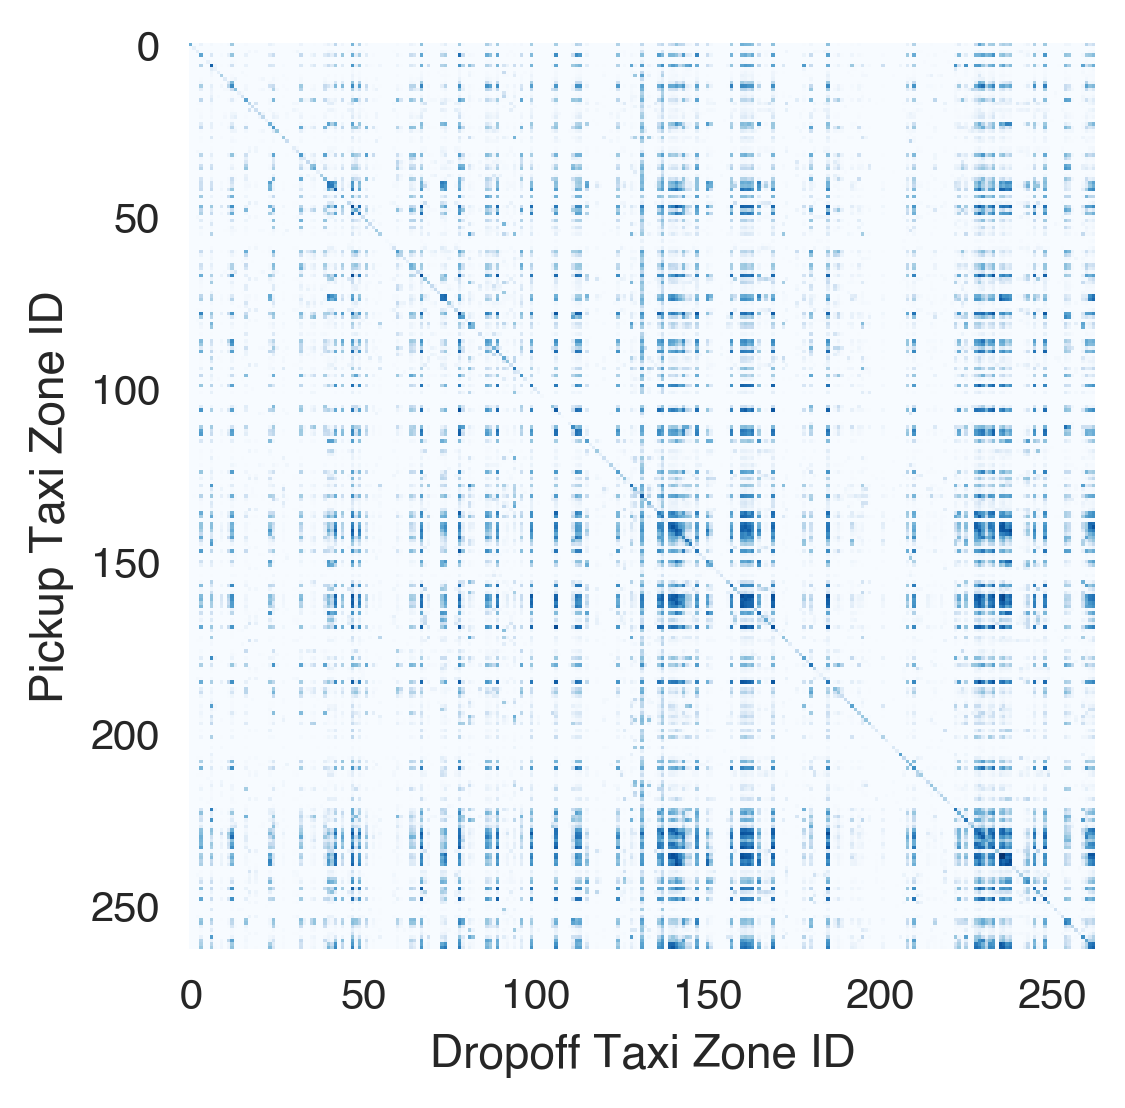

In [34]:
# <!-- collapse=True -->
plt.imshow(count_matrix[1:-3, 1:-3].T, norm=symlog(10000), origin='upper', cmap=plt.cm.Blues)
plt.grid(False)
plt.xlabel("Dropoff Taxi Zone ID")
plt.ylabel("Pickup Taxi Zone ID")
plt.gcf().set_size_inches(4, 4)

# Section 3: Calculate Pickups matrix and decomposition

In [4]:
df = dd.read_parquet('/data/all_trips.parquet', engine='fastparquet', index='pickup_datetime',
                     columns=['pickup_taxizone_id',])
df['pickup_taxizone_id'] = df.pickup_taxizone_id.fillna(266.).astype(np.int32)

/home/shekhar/anaconda3/lib/python3.6/site-packages/fastparquet/api.py:436: UserWarning: Regression warning: found category spec from fastparquet <= 0.0.6
  warnings.warn('Regression warning: found category spec from '


In [5]:
def get_year_mo_day(data, col):
#     d = np.core.defchararray.replace(np.core.defchararray.add(data.index.values.astype('M8[h]').astype(np.str), ":00"), 'T', ' ')
#     return d
    return data.index.values.astype('M8[h]')

In [6]:
df['pickup_ymd'] = df.map_partitions(get_year_mo_day, 'pickup_datetime', meta=('asdf', np.datetime64))

/home/shekhar/anaconda3/lib/python3.6/site-packages/dask/dataframe/utils.py:232: FutureWarning: Passing in 'datetime64' dtype with no frequency is deprecated and will raise in a future version. Please pass in 'datetime64[ns]' instead.
  return pd.Series([], dtype=dtype, name=name, index=index)


In [10]:
df.reset_index().rename(columns=dict(index='N')).tail()

,N,pickup_taxizone_id,pickup_ymd
1432504,2016-12-31 23:59:57,36,2016-12-31 23:00:00
1432505,2016-12-31 23:59:58,76,2016-12-31 23:00:00
1432506,2016-12-31 23:59:58,168,2016-12-31 23:00:00
1432507,2016-12-31 23:59:58,144,2016-12-31 23:00:00
1432508,2016-12-31 23:59:59,135,2016-12-31 23:00:00


In [11]:
pickup_counts_df = df.reset_index().rename(columns=dict(index='N')).groupby(['pickup_ymd', 'pickup_taxizone_id',]).count().compute()

In [12]:
pickup_counts_df

N
pickup_ymd          pickup_taxizone_id     
2009-01-01 00:00:00 4                   121
                    7                    42
                    12                    4
                    13                   63
                    14                    2
                    17                   13
                    18                    1
                    19                    1
                    22                    1
                    23                    3
                    24                   78
                    25                   28
                    28                    3
                    32                    1
                    33                   29
                    34                    1
                    36                    3
                    37                   16
                    40                   27
                    41                   53
                    42                   30
                    43                  207
                    45                   21
                    48                  594
                    49                   18
                    50                  178
                    52                   24
                    54                    1
                    56                    1
                    61                    5
                    62                    2
                    65                   14
                    66                   13
                    68                  484
                    69                    1
                    70                    1
                    74                   60
                    75                  120
                    78                    1
                    79                  729
                    80                   36
                    82                    7
                    83                    3
                    87                   90
                    88                   33
                    89                    2
                    90                  383
                    92                    1
                    93                    1
                    95                   16
                    97                   34
                    100                 118
                    106                   5
                    107                 509
                    112                  40
                    113                 286
                    114                 301
                    116                  29
                    120                   1
                    121                   1
                    125                  73
                    127                   2
                    128                   1
                    129                  13
                    132                  76
                    133                   2
                    136                   1
                    137                 242
                    138                  69
                    140                 193
                    141                 480
                    142                 401
                    143                 153
                    144                 196
                    145                  26
                    146                   8
                    148                 365
                    151                 140
                    152                  27
                    155                   1
                    158                 220
                    161                 454
                    162                 255
                    163                 219
                    164                 313
                    166                 143
                    168                  12
                    169                   2
                    170                 491
                    173               

In [7]:
df['pickup_ymd'] = df.map_partitions(get_year_mo_day, 'pickup_datetime', meta=('asdf', str))


In [8]:
df.tail()

,pickup_taxizone_id,dropoff_taxizone_id,pickup_ymd
pickup_datetime,,,
2016-12-31 23:59:57,36,36,2016-12-31:00
2016-12-31 23:59:58,76,63,2016-12-31:00
2016-12-31 23:59:58,168,161,2016-12-31:00
2016-12-31 23:59:58,144,209,2016-12-31:00
2016-12-31 23:59:59,135,134,2016-12-31:00


In [82]:
df_counts = df.groupby(['pickup_ymdh', 'pickup_taxizone_id', 'dropoff_taxizone_id']).count()

In [84]:
df_counts.reset_index(drop=True).head()

MemoryError: 

In [7]:
df_counts.columns = ['count']

In [8]:
df_counts = df_counts.repartition(npartitions=100)

In [9]:
df_counts.to_parquet('/data/trips_timeseries_counts.parquet', compression="SNAPPY", write_index=True)

MemoryError: 

In [ ]:
df_counts = dd.read_parquet('/data/trips_timeseries_counts.parquet')

In [ ]:
df_counts.head()

In [ ]:
i = 0
for x in df_counts.itertuples():
    print(x)
    i += 1
    if i > 10:
        break

In [ ]:
# df_counts = df_counts.reset_index()

In [ ]:
# !rm -rf /data/trips_timeseries_counts.parquet

In [ ]:
# df_counts.to_parquet('/data/trips_timeseries_counts.parquet', compression="SNAPPY")

In [ ]:
df_counts = dd.read_parquet('/data/trips_timeseries_counts.parquet')

In [ ]:
df_counts.head()

In [ ]:
df_counts['pickup_ymd'] = df_counts.pickup_ymd.astype(str)
grouped_counts = df_counts.groupby('pickup_ymd')

In [ ]:
tzdf = geopandas.read_file('../shapefiles/taxi_zones.shp')

In [ ]:
tzdf.tail()

In [ ]:
assert(tzdf.LocationID.max() == 263) # If the shapefile changes, this should catch it.

In [ ]:
fh = netCDF4.Dataset('/data/trips_tensor.nc', 'w', format='NETCDF4',  clobber=True)

In [ ]:
time_dim = fh.createDimension('time', None)
pickup_dim = fh.createDimension('pickup_taxizone_id', 267)
dropoff_dim = fh.createDimension('dropoff_taxizone_id', 267)

pickup_var = fh.createVariable('pickup_taxizone_id', str, dimensions=('pickup_taxizone_id',), zlib=True)
dropoff_var = fh.createVariable('dropoff_taxizone_id', str, dimensions=('dropoff_taxizone_id',), zlib=True)
time_var = fh.createVariable('time', 'f8', dimensions=('time'), zlib=True)

In [ ]:
pickup_var[1:264] = tzdf.zone.values
pickup_var[264:] = np.array(["Unknown", "Unknown", "Unknown"])
pickup_var[0] = "Unknown"

pickup_var.long_name = 'pickup_taxizone_id'
pickup_var.units = '1'

dropoff_var[:] = pickup_var[:]
dropoff_var.long_name = 'dropoff_taxizone_id'
dropoff_var.units = '1'

In [ ]:
time_var[:] = netCDF4.date2num(pd.date_range('2009-01-01', '2016-12-31', freq='D').to_pydatetime(), 
                               units='hours since 2009-01-01 00:00:00')
time_var.standard_name = 'time'
time_var.units = 'hours since 2009-01-01 00:00:00'

In [ ]:
timeindex_lookup_dict = dict(zip(pd.date_range('2009-01-01', '2016-12-31', freq='D') \
                                 .astype(str).values, range(time_var.shape[0])))

In [ ]:
assert(df_counts.pickup_ymd.unique().compute().shape[0] == time_dim.size)

In [ ]:
counts_var = fh.createVariable('counts', 'u2', dimensions=('time', 'dropoff_taxizone_id', 'pickup_taxizone_id'),
                               zlib=True, fill_value=0, complevel=9
                              )

In [ ]:
counts_var.shape

In [ ]:
counts_var[:, :, :] = 0

In [ ]:
counts_var

In [ ]:
netCDF4.date2index(pd.DatetimeIndex(df_counts.pickup_ymd.compute()).to_pydatetime(), 
                   time_var, select='exact'
                  )

In [ ]:
fh.close()